# Iterative Ensemble Smoother with the Burgers PDE

Using IES to estimate viscosity.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
rng = np.random.default_rng(12345)

from p_tqdm import p_map
from ipywidgets import interact
import ipywidgets as widgets

from iterative_ensemble_smoother import IterativeEnsembleSmoother

In [2]:
%load_ext autoreload
%autoreload 2
from dass import pde, utils, analysis, taper

In [3]:
nx = 41
ny = 41

# time steps
k_start = 0
k_end = 500

In [4]:
u = pde.burgers(nx=nx, ny=ny, nt=k_end, nu=0.1)

In [5]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True response")
    p = ax.pcolormesh(u[k])
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_truth(k)>

Number of observations:  4000


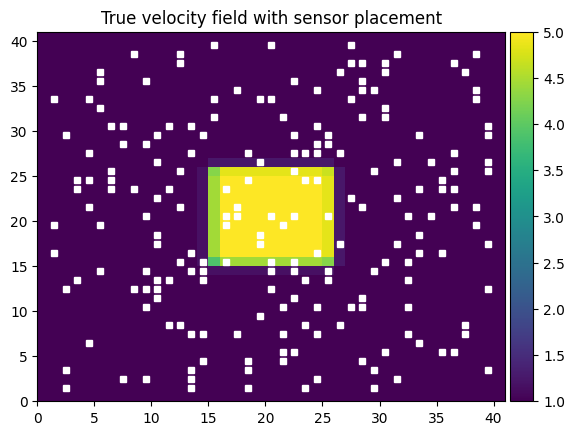

In [6]:
# placement of sensors, i.e, where the observations are done
pad = 1
coords = np.array([(x, y) for x in range(pad, nx - pad) for y in range(pad, nx - pad)])
ncoords = coords.shape[0]
nmeas = 200
coords_idx = np.random.choice(np.arange(ncoords), size=nmeas, replace=False)
obs_coordinates = [utils.Coordinate(xc, yc) for xc, yc in coords[coords_idx]]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 20, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u, lambda value: abs(0.01 * value))
# number of measurements
m = d.shape[0]
print("Number of observations: ", m)

# Plot temperature field and show placement of sensors.
obs_coordinates = set(zip(d.index.get_level_values("x"), d.index.get_level_values("y")))
x, y = zip(*obs_coordinates)

fig, ax = plt.subplots()
p = ax.pcolormesh(u[0], cmap=plt.cm.viridis)
ax.set_title("True velocity field with sensor placement")
utils.colorbar(p)
ax.plot([i + 0.5 for i in x], [j + 0.5 for j in y], "s", color="white", markersize=5)

In [7]:
# Number of realisations
N = 100

In [8]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

In [9]:
# List of matrices of size (nx, nx) containing priors.
# The reason for having a list is that `p_map` requires it.
# `p_map` runs stuff in parallel.
A_IES = rng.uniform(low=0.0, high=0.6, size=N)

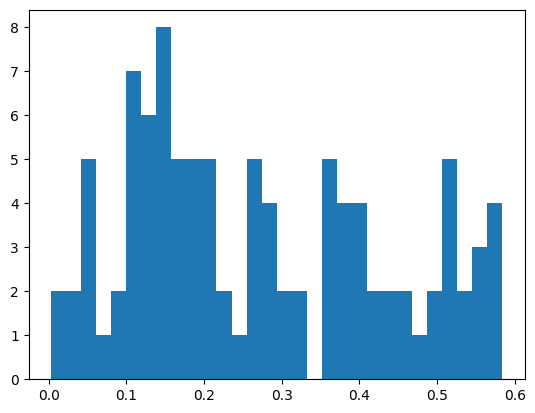

In [10]:
fig, ax = plt.subplots()
ax.hist(A_IES, bins=30);

In [11]:
def get_steplength(iteration_nr: int) -> float:
    """
    This is an implementation of Eq. (49), which calculates a suitable step length for
    the update step, from the book:

    Geir Evensen, Formulating the history matching problem with consistent error statistics,
    Computational Geosciences (2021) 25:945 –970
    """
    max_steplength: float = 0.6
    min_steplength: float = 0.3
    dec_steplength: float = 2.5
        
    steplength = min_steplength + (
        max_steplength - min_steplength
    ) * pow(2, -(iteration_nr - 1) / (dec_steplength - 1))
    return steplength

In [12]:
# Coefficient matrix as defined in Eq. 16 and Eq. 17.
W = np.zeros(shape=(N, N))

A_IES_ert = A_IES.copy()

Running forward model.:   0%|          | 0/100 [00:00<?, ?it/s]

265 measurements will be deactivated.


Running forward model.:   0%|          | 0/100 [00:00<?, ?it/s]

736 measurements will be deactivated.


Running forward model.:   0%|          | 0/100 [00:00<?, ?it/s]

2015 measurements will be deactivated.


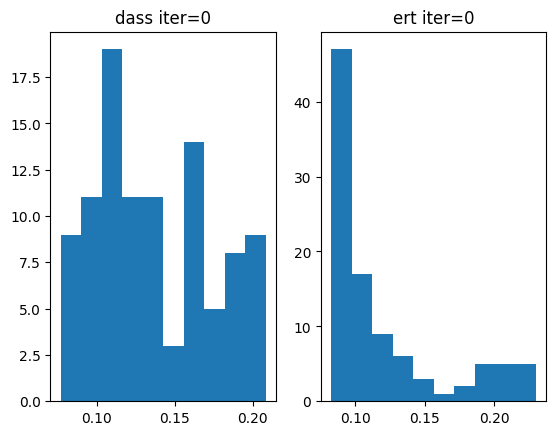

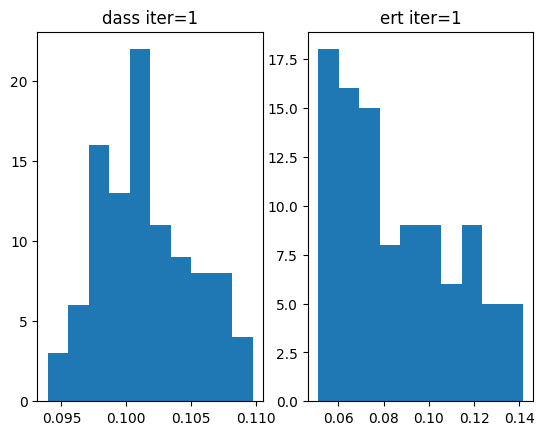

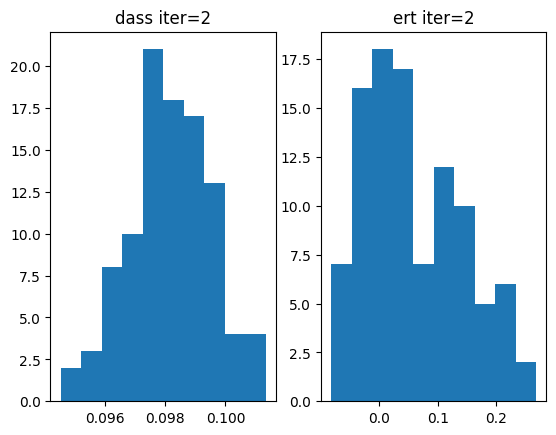

In [13]:
for i in range(3):
    
    # Step length in Gauss Newton
    gamma = get_steplength(i)
    
    fwd_runs = p_map(
        pde.burgers,
        [nx] * N,
        [ny] * N,
        [k_end] * N,
        A_IES,
        desc=f"Running forward model.",
    )
    
    # Assume diagonal ensemble covariance matrix for the measurement perturbations.
    Cdd = np.diag(d.sd.values**2)

    # 9.4 Ensemble representation for measurements
    E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
    E = E - E.mean(axis=1, keepdims=True)
    assert E.shape == (m, N)

    D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

    Y = np.array(
        [
            fwd_run[
                d.index.get_level_values("k").to_list(),
                d.index.get_level_values("y").to_list(),
                d.index.get_level_values("x").to_list(),
            ]
            for fwd_run in fwd_runs
        ]
    ).T

    assert Y.shape == (
        m,
        N,
    ), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

    # We expect that a certain number of points gets deactivated,
    # since not all cells are changing values due to the way the model works.
    enough_ens_var_idx = Y.var(axis=1) > 1e-6
    print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
    Y = Y[enough_ens_var_idx, :]
    D = D[enough_ens_var_idx, :]
    Cdd = Cdd[enough_ens_var_idx, :]
    Cdd = Cdd[:, enough_ens_var_idx]
    
    W = analysis.IES(Y, D, Cdd, W, gamma)
    X_IES = np.identity(N) + W
    A_IES = A_IES @ X_IES
    
    A_IES_ert = IterativeEnsembleSmoother(N).update_step(
        Y,
        A_IES_ert.reshape(1, -1),
        d.sd.values[enough_ens_var_idx],
        d.value.values[enough_ens_var_idx],
        step_length=gamma
    )
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].hist(A_IES)
    ax[0].set_title(f"dass iter={i}")
    ax[1].hist(A_IES_ert.ravel())
    ax[1].set_title(f"ert iter={i}")
    

In [14]:
print("Dass mean: ", np.mean(A_IES))
print("ERT mean: ", np.mean(A_IES_ert))

Dass mean:  0.09816563434985812
ERT mean:  0.05987033201404122


In [15]:
def interactive_realisations(k, n):
    fig, ax = plt.subplots()
    fig.suptitle(f"Velocity field for realisation {n}")
    p = ax.pcolormesh(fwd_runs[n][k])
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_realisations,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=499), IntSlider(value=0, description='n', max=99…

<function __main__.interactive_realisations(k, n)>